In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import plotly.graph_objs as go

### Constants:

In [2]:
ALPHA = 0.05
BETA = 0.2

### Read file:

In [3]:
df = pd.read_csv("ab_made_4.gzip", compression='gzip')

In [4]:
pre_group_df = df[df['group'].isna()]
a_group_df = df[df['group'] == 'A']
b_group_df = df[df['group'] == 'B']

In [5]:
print(
    f"Даты pre-периода лежат в промежутке с {pre_group_df['date'].min()} по {pre_group_df['date'].max()}"
)
print(
    f"Даты A-группы лежат в промежутке с {a_group_df['date'].min()} по {a_group_df['date'].max()}"
)
print(
    f"Даты B-группы лежат в промежутке с {b_group_df['date'].min()} по {b_group_df['date'].max()}"
)

Даты pre-периода лежат в промежутке с 2023-04-01 по 2023-04-30
Даты A-группы лежат в промежутке с 2023-05-01 по 2023-05-31
Даты B-группы лежат в промежутке с 2023-05-01 по 2023-05-31


In [6]:
print(f"Кол-во пользователей для pre-периода равно {pre_group_df['id_user'].nunique()}")
print(f"Кол-во пользователей для A-группы равно {a_group_df['id_user'].nunique()}")
print(f"Кол-во пользователей для B-группы равно {b_group_df['id_user'].nunique()}")

Кол-во пользователей для pre-периода равно 10000
Кол-во пользователей для A-группы равно 6000
Кол-во пользователей для B-группы равно 6000


In [7]:
print(f"Кол-во событий для pre-периода равно {pre_group_df['id_user'].count()}")
print(f"Кол-во событий для A-группы равно {a_group_df['id_user'].count()}")
print(f"Кол-во событий для B-группы равно {b_group_df['id_user'].count()}")

Кол-во событий для pre-периода равно 25759
Кол-во событий для A-группы равно 15389
Кол-во событий для B-группы равно 15257


### Посмотрим на выбросы и попробуем заменить их на значение выбранного верхнего перцентиля, то есть, грубо говоря, ограничить значение:

In [8]:
threshold = 0.01

#### Pre-group:

In [9]:
# сначала посмотрим на выбросы, которые кажутся прямо таки аномальными
lower_bound = pre_group_df.sum_payment.quantile(q=threshold)
upper_bound = pre_group_df.sum_payment.quantile(q=1-threshold)
emission_df = pre_group_df[
    (pre_group_df.sum_payment < lower_bound) | (pre_group_df.sum_payment > upper_bound)
]

In [10]:
pre_group_df.loc[
    pre_group_df.index.isin(emission_df.index), "sum_payment"
] = pre_group_df.loc[pre_group_df.index.isin(emission_df.index), "sum_payment"].apply(
    lambda x: min(x, upper_bound)
)

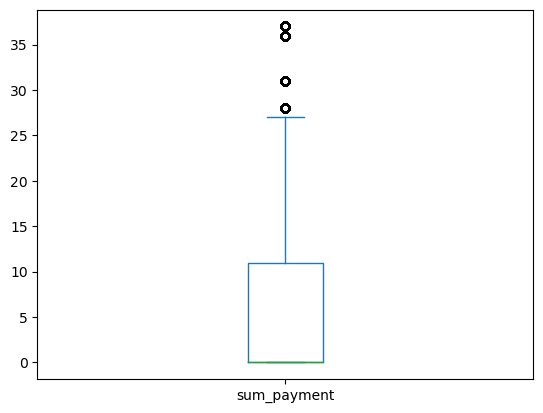

In [11]:
_, bp = pre_group_df.sum_payment.plot.box(return_type='both')

#### A-group:

In [12]:
# сначала посмотрим на выбросы, которые кажутся прямо таки аномальными
lower_bound = a_group_df.sum_payment.quantile(q=threshold)
upper_bound = a_group_df.sum_payment.quantile(q=1-threshold)
emission_df = a_group_df[
    (a_group_df.sum_payment < lower_bound) | (a_group_df.sum_payment > upper_bound)
]

In [13]:
a_group_df.loc[
    a_group_df.index.isin(emission_df.index), "sum_payment"
] = a_group_df.loc[a_group_df.index.isin(emission_df.index), "sum_payment"].apply(
    lambda x: min(x, upper_bound)
)

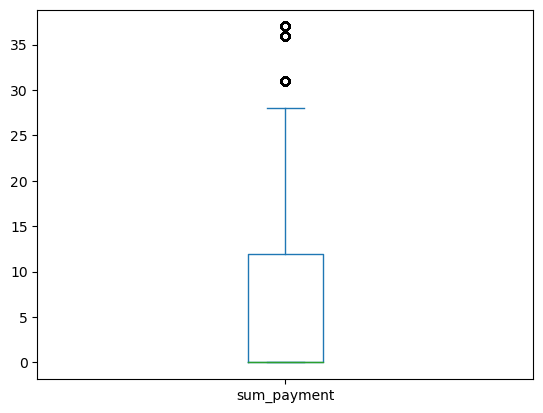

In [14]:
_, bp = a_group_df.sum_payment.plot.box(return_type='both')

#### B-group:

In [15]:
# сначала посмотрим на выбросы, которые кажутся прямо таки аномальными
lower_bound = b_group_df.sum_payment.quantile(q=threshold)
upper_bound = b_group_df.sum_payment.quantile(q=1-threshold)
emission_df = b_group_df[
    (b_group_df.sum_payment < lower_bound) | (b_group_df.sum_payment > upper_bound)
]

In [16]:
b_group_df.loc[
    b_group_df.index.isin(emission_df.index), "sum_payment"
] = b_group_df.loc[b_group_df.index.isin(emission_df.index), "sum_payment"].apply(
    lambda x: min(x, upper_bound)
)

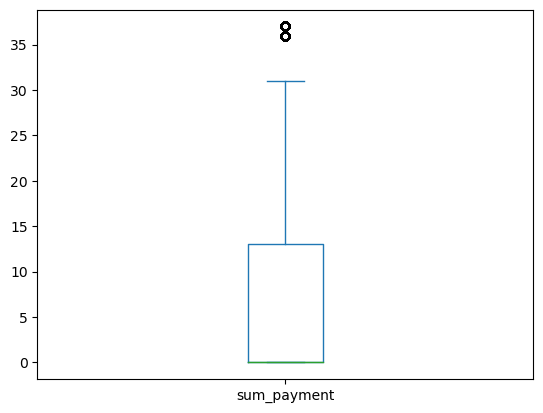

In [17]:
_, bp = b_group_df.sum_payment.plot.box(return_type='both')

### Рассчитаем длительность:

In [18]:
def metric(df):
    return df.groupby('id_user').sum_payment.sum().tolist()

In [19]:
def duration(k, delta_effect, sigma_1, sigma_2, alpha=ALPHA, beta=BETA):
    z = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * z ** 2 * (sigma_1 ** 2 + sigma_2 **2 / k) / (delta_effect ** 2)
    return n

In [20]:
sigma_1 = sigma_2 = np.std(metric(pre_group_df))

mean_base = np.mean(metric(pre_group_df))
effect = 0.1 * mean_base

k = a_group_df['id_user'].nunique() / b_group_df['id_user'].nunique()

In [21]:
target_n = int(duration(k, effect, sigma_1, sigma_2, alpha=0.05, beta=0.2)/2)

In [22]:
print(f"Достаточное количество человек в каждой группе: {target_n}")

Достаточное количество человек в каждой группе: 3169


### Фильтранем даты:

In [23]:
a_date_filtering_df = a_group_df.groupby('date').size().reset_index(name='events') 
a_date_filtering_df['cumsum'] = a_date_filtering_df['events'].cumsum()

b_date_filtering_df = b_group_df.groupby('date').size().reset_index(name='events') 
b_date_filtering_df['cumsum'] = b_date_filtering_df['events'].cumsum()

In [24]:
a_date = a_date_filtering_df.loc[
    a_date_filtering_df["cumsum"] >= target_n, "date"
].min()
b_date = b_date_filtering_df.loc[
    b_date_filtering_df["cumsum"] >= target_n, "date"
].min()

if a_date == b_date:
    date = a_date
else:
    date = max(a_date, b_date)

In [25]:
a_group_new_df =  a_group_df[a_group_df['date'] <= date]
b_group_new_df =  b_group_df[b_group_df['date'] <= date]

### Анализ эксперимента:

In [26]:
def dynamic_metric(a_df, b_df):
    final_df = pd.DataFrame(
        [],
        columns=["metric_a", "metric_b", "effect", "t", "p_value"],
        index=a_df["date"].drop_duplicates(),
    )
    for date in a_df["date"].drop_duplicates():
        tmp_a = metric(a_df[a_df["date"] <= date])
        tmp_b = metric(b_df[b_df["date"] <= date])
        effect = np.mean(tmp_b) - np.mean(tmp_a)
        results = sps.ttest_ind(tmp_a, tmp_b)
        t, p_value = results.statistic, results.pvalue
        final_df.loc[date] = np.mean(tmp_a), np.mean(tmp_b), effect, t, p_value
    return final_df

In [27]:
results = dynamic_metric(a_group_new_df, b_group_new_df)

### Посмотрим на финальные результаты:

In [28]:
results.tail(1)

,metric_a,metric_b,effect,t,p_value
date,,,,,
2023-05-18,9.709397,10.77454,1.065143,-2.113778,0.034597


### Посмотрим данные в динамике:

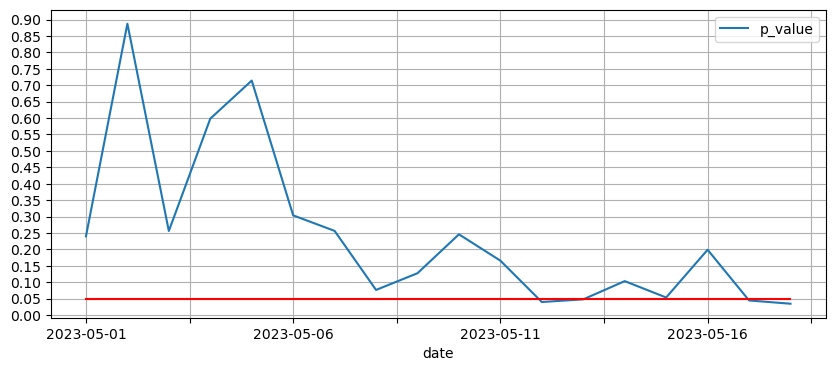

In [29]:
results.plot(y='p_value', figsize=(10, 4), grid=True, yticks=np.arange(0, 1, 0.05))
plt.plot([ALPHA] * len(results.index), color='red')
plt.show()